# First: load imports needed for the project and preparation of the project

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 203 (delta 125), reused 26 (delta 12), pack-reused 0
Receiving objects: 100% (203/203), 3.89 MiB | 8.43 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla P100-PCIE-16GB


In [3]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.5
PyTorch: 1.10.0+cu111
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the previous value).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [7]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [8]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [9]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [10]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [11]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very dofferent. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [12]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [13]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 723.48it/s]


In [14]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1142.68it/s]


In [15]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 923.09it/s]


In [16]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [17]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [18]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


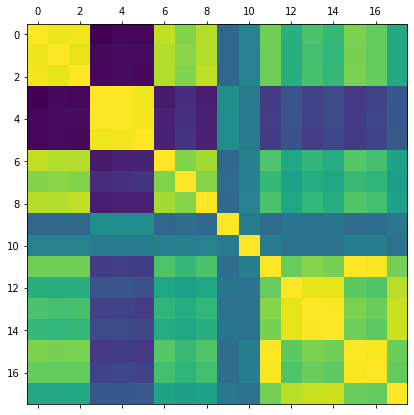

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810274, 0.16335739298653476, 0.07511546472382995, 0.054921627068028424, 0.05390616867076577, 0.04952232661739343, 0.022486349463995598, 0.013932731902136385, 0.012792662672300325, 0.009829012007199104, 0.004024926426955747, 0.002893959610103366, 0.002163271201445878, 0.001741116222641519, 0.0006928432299862775, 0.00021826337426103455, 0.00023351820917083064, 0.0004035851322244031]


In [19]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Preparation Training and Test set

Once the dataset is prepared, make batches of data,put them togheter in an array and split them into train and test sets.
After looking through the dataset and the features, i decided to takeonly the values with a timestap of a weekday between 4:00 and 19:30. In many of the features in the interval outside those timestamps there i only noise, which can be a sign that the machine is off in that time interval.

In [20]:
def create_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=64,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=64,
      shuffle=True
  )

  return loader_train, loader_test

In [21]:
loader_train, loader_test = create_dataloaders(dataset_norm)

100%|██████████| 63359/63359 [00:33<00:00, 1883.72it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [22]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.4737866011131492
Standard deviation Loss of baselinemodel:  0.09320007350491984


Test set
Mean Loss of baselinemodel:  0.4659305717607941
Standard deviation Loss of baselinemodel:  0.08776944196887589




# Train a simple Feed Forward Neural Network

I trained a simple FFN Network to have a second baseline model. The final model training should have also a better performance than this FFN.

In [23]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 360)
        self.linear3 = nn.Linear(360, 360)
        self.linear4 = nn.Linear(360, 180)
        self.linear5 = nn.Linear(180, D_out)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        x = torch.relu(self.linear4(x))
        return self.linear5(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [24]:
n_epochs = 50
lr=0.01

# Create model FFN instance
model_FFN_whole = ANN_relu(18, 18).to(device)
print(model_FFN_whole)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN_whole.parameters(), lr=lr)


train_FFN = False

params_not_trained_whole = model_FFN_whole.parameters()

if train_FFN is True:
  trained_model_FFN_whole , train_losses_whole, test_losses_whole = train(model_FFN_whole, criterion, optimizer_whole, loader_train, loader_test, n_epochs)


ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=360, bias=True)
  (linear3): Linear(in_features=360, out_features=360, bias=True)
  (linear4): Linear(in_features=360, out_features=180, bias=True)
  (linear5): Linear(in_features=180, out_features=18, bias=True)
)


In [26]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_whole))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_whole], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_whole], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()


We do the same process with the Weekend dataset and the Weekdays dataset, to see if its any improve taking only those datasets



In [29]:
loader_train_weekdays, loader_test_weekdays = create_dataloaders(dataset_weekdays_norm)
loader_train_weekend, loader_test_weekend = create_dataloaders(dataset_weekend_norm)

criterion = nn.MSELoss()

losses_train_weekdays = []

for i in loader_train_weekdays:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train_weekdays.append(loss.item())

losses_test_weekend = []

for i in loader_test_weekend:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test_weekend.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel Weekdays: ", np.mean(losses_train_weekdays))
print("Standard deviation Loss of baselinemodel Weekdays: ", np.std(losses_train_weekdays))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel Weekend: ", np.mean(losses_test_weekend))
print("Standard deviation Loss of baselinemodel Weekend: ", np.std(losses_test_weekend))
print('\n')

100%|██████████| 29791/29791 [00:15<00:00, 1872.04it/s]


length of training set (whole dataset): 26811
length of test set (whole dataset): 2980




100%|██████████| 33567/33567 [00:17<00:00, 1908.39it/s]


length of training set (whole dataset): 30210
length of test set (whole dataset): 3357


Training set
Mean Loss of baselinemodel Weekdays:  0.42486975091311696
Standard deviation Loss of baselinemodel Weekdays:  0.11349020780204344


Test set
Mean Loss of baselinemodel Weekend:  0.7605142109798935
Standard deviation Loss of baselinemodel Weekend:  0.11978187220861101




In [31]:
n_epochs = 50
lr=0.01

# Create model FFN instance
model_FFN_weekday = ANN_relu(18, 18).to(device)
print(model_FFN_weekday)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_weekday = torch.optim.SGD(model_FFN_weekday.parameters(), lr=lr)


train_FFN = False

params_not_trained_weekday = model_FFN_weekday.parameters()

if train_FFN is True:
  trained_model_FFN_weekday , train_losses_weekday, test_losses_weekday = train(model_FFN_weekday, criterion, optimizer_weekday, loader_train_weekdays, loader_test_weekdays, n_epochs)


n_epochs = 50
lr=0.01

# Create model FFN instance
model_FFN_weekend = ANN_relu(18, 18).to(device)
print(model_FFN_weekend)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_weekend = torch.optim.SGD(model_FFN_weekend.parameters(), lr=lr)


train_FFN = False

params_not_trained_weekend = model_FFN_weekend.parameters()

if train_FFN is True:
  trained_model_FFN_weekend , train_losses_weekend, test_losses_weekend = train(model_FFN_weekend, criterion, optimizer_weekend, loader_train_weekend, loader_test_weekend, n_epochs)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=360, bias=True)
  (linear3): Linear(in_features=360, out_features=360, bias=True)
  (linear4): Linear(in_features=360, out_features=180, bias=True)
  (linear5): Linear(in_features=180, out_features=18, bias=True)
)
ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=360, bias=True)
  (linear3): Linear(in_features=360, out_features=360, bias=True)
  (linear4): Linear(in_features=360, out_features=180, bias=True)
  (linear5): Linear(in_features=180, out_features=18, bias=True)
)


In [32]:
if train_FFN is True:

  # Show results of the loss function weekdays

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train_weekdays) for i in range(len(train_losses_weekday))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_weekday], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_weekday], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Weekday dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

  # Show results of the loss function weekends

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train_weekend) for i in range(len(train_losses_weekend))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_weekend], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_weekend], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Weekend dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Conclusions FFN

We can see that using the weekends or weekdays dataset doesn't bring any improvement. Therefore we can forget them and use only the whole dataset for the next models.

# RNN Model

We train before a standard RNN and see which results we can expected with a small and easy solution.
I am using this template (https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb) and make changes using it as a base.

1) torch.nn.RNN (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

Parameters
* input_size – The number of expected features in the input x
* hidden_size – The number of features in the hidden state h
* num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1
* nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'
* bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
* dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
* bidirectional – If True, becomes a bidirectional RNN. Default: False

2) torch.nn.Linear (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

Parameters
* in_features – size of each input sample
* out_features – size of each output sample
* bias – If set to False, the layer will not learn an additive bias. Default: True


In [33]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, device, batch_first = True, dropout = 0):
        super(RNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device

        #Defining the layers
        self.fc1 = nn.Linear(input_size, input_size)
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_size = hidden_dim, num_layers = n_layers, batch_first = batch_first, nonlinearity='relu', dropout = dropout)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size).to(self.device)

        out = torch.relu(self.fc1(x))

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(out, hidden)

        out = torch.relu(out)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [34]:
def training_RNN(model, criterion, optimizer, train_loader, test_loader, n_epochs):

  epoch_loss_train = []
  epoch_loss_test = []

  # Training Run
  for epoch in range(1, n_epochs + 1):

    print(f'Epoch {epoch}')

    losses_train = []
    losses_test = []

    model.train()

    optimizer.zero_grad()

    print('\nTraining:')
    for i in tqdm(train_loader):

      input = i[0]

      target = i[1]

      output, hidden = model_rnn(input)

      #Compute loss
      loss = criterion(output, target)

      #Backpropagation
      loss.backward()

      #Optimization
      optimizer.step()

    print('\nTest with training set')
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):
        input = i[0]
        target = i[1]

        output, hidden = model(input)

        #Compute loss
        losses_train.append (float(criterion(output, target).item()))

    print('\nTest with test set')
    model.eval()
    with torch.no_grad():
      for i in tqdm(test_loader):
        input = i[0]
        target = i[1]

        output, hidden = model(input)

        #Compute loss
        losses_test.append (float(criterion(output, target).item()))


    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(np.mean(losses_train))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(np.mean(losses_test))

    print('\n')

  return epoch_loss_train, epoch_loss_test, model

In [35]:
# Instantiate the model with hyperparameters
model_rnn = RNN(input_size = 18,
                output_size = 18,
                hidden_dim = 64,
                n_layers = 1,
                batch_first = True,
                dropout = 0,
                device = device)

# We'll also set the model to the device that we defined earlier (default is CPU)
model_rnn = model_rnn.to(device)

# Define hyperparameters
n_epochs = 50
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr)

train_RNN = False

if train_RNN is True:
  train_losses, test_losses, trained_model_RNN = training_RNN(model_rnn, criterion, optimizer, loader_train, loader_test, n_epochs)

In [36]:
if train_RNN is True:

  # Show results of the loss function

  fig = plt.figure()

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses))]

  ax.plot(baseline)
  ax.plot([np.mean(i) for i in train_losses])
  ax.plot([np.mean(i) for i in test_losses])
  ax.set_title("Mean Squared Error RNN")
  fig.canvas.draw()

The last basemodel i am going to use is a simple RNN. The final model should also have a better performance than this RNN.

In [50]:
def create_sequece_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one sequence of 30 measures (18 features) and target are the next sequence of 30 
  # measures (18 features)). When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    target = np.array(dataset_norm.iloc[i+30:i+60, 1:])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=15,
      shuffle=False
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=15,
      shuffle=False
  )

  return loader_train, loader_test

In [38]:
loader_train, loader_test = create_sequece_dataloaders(dataset_norm)

100%|██████████| 63300/63300 [00:35<00:00, 1769.80it/s]


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [40]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.7443867036312615
Standard deviation Loss of baselinemodel:  0.11228539154408188


Test set
Mean Loss of baselinemodel:  0.750549325445817
Standard deviation Loss of baselinemodel:  0.10785673408274579




# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).


In [44]:
def positional_encoding(seq_len: int, dim_model: int, device):
    
    # Tensor with the positions of every sequence element (0 to seq_len)
    pos = torch.arange(seq_len, dtype=float32, device=device).reshape(1, -1, 1)
    
    # Tensor with the positions of every feature in the sequence (0 to dim_model)
    dim = torch.arange(dim_model, dtype=float32, device=device).reshape(1, 1, -1)

    phase = pos / (1e4 ** (torch.div(dim, dim_model, rounding_mode='floor')))

    position_encoding = torch.where(dim.long() % 2 == 0, sin(phase), cos(phase))

    return position_encoding.to(device)


class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)
        
    def forward (self, src):
        
        mask = self.generate_square_mask(len(src))

        #src_pos = src + positional_encoding(src.shape[1], src.shape[2], self.device)

        output = self.encoder (src, mask)
        
        output = self.decoder (src, output, mask)
        
        return output

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [45]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')

    print('Training:')
    model.train()

    for i in tqdm(train_loader):

      # Initialize optimizer gradients
      optimizer.zero_grad()

      input = i[0]

      target = i[1]

      net_out = model.forward(input)

      #Compute loss
      loss = criterion(net_out, target)

      #Backpropagation
      loss.backward()

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with training set')
    losses_test = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(test_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [46]:
# Initialize Transformer Model and Optimizer

model_transformer = Transformer (num_encoder_layers=3,
                     num_decoder_layers=3,
                     feature_size=18,
                     output_size=18,
                     num_heads=3,
                     device = device,
                     batch_first=False)

n_epochs = 50

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')


train_transformer = True

if train_transformer is True:
  trained_model_transformer, train_losses, test_losses = training_transformer(model_transformer, optimizer, criterion, loader_train, loader_test, n_epochs)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 50
Training:


100%|██████████| 3798/3798 [01:42<00:00, 36.92it/s]



Test with training set


100%|██████████| 3798/3798 [00:24<00:00, 157.02it/s]



Current Mean loss Train Set:  1.0027310190513423

Test with training set


100%|██████████| 422/422 [00:02<00:00, 156.66it/s]



Current Mean loss Test Set:  1.0083856126425956


Epoch: 2 of 50
Training:


100%|██████████| 3798/3798 [01:42<00:00, 36.98it/s]



Test with training set


100%|██████████| 3798/3798 [00:23<00:00, 159.56it/s]



Current Mean loss Train Set:  1.002175686216907

Test with training set


100%|██████████| 422/422 [00:02<00:00, 159.98it/s]



Current Mean loss Test Set:  1.007734998283793


Epoch: 3 of 50
Training:


  7%|▋         | 257/3798 [00:06<01:35, 37.04it/s]


KeyboardInterrupt: ignored

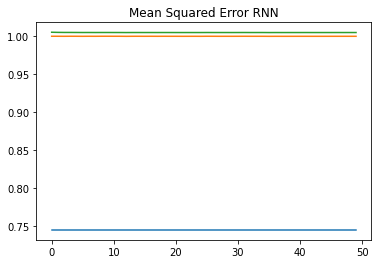

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure()

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses))]

  ax.plot(baseline)
  ax.plot([np.mean(i) for i in train_losses])
  ax.plot([np.mean(i) for i in test_losses])
  ax.set_title("Mean Squared Error RNN")
  fig.canvas.draw()

In [52]:
def create_sequece_pairs(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one sequence of 30 measures (18 features) and target are the next sequence of 30 
  # measures (18 features)). When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    target = np.array(dataset_norm.iloc[i+30:i+60, 1:])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  return (training_data, training_target), (test_data, test_target)

In [61]:
train_pairs, test_pairs = create_sequece_pairs(dataset_norm)

100%|██████████| 63300/63300 [00:34<00:00, 1841.23it/s]


In [62]:
print(type(train_pairs))

criterion = nn.MSELoss()

losses_train = []

for i in train_pairs:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in test_pairs:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

<class 'tuple'>
Training set
Mean Loss of baselinemodel:  0.8073254525661469
Standard deviation Loss of baselinemodel:  0.048481136560440063


Test set
Mean Loss of baselinemodel:  0.3840979039669037
Standard deviation Loss of baselinemodel:  0.11812558770179749




In [70]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')

    print('Training:')
    model.train()

    for i in tqdm(train_loader):

      # Initialize optimizer gradients
      optimizer.zero_grad()

      input = i[0]

      target = i[1]

      net_out = model.forward(input)

      #Compute loss
      loss = criterion(net_out, target)

      #Backpropagation
      loss.backward()

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with training set')
    losses_test = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(test_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [71]:
# Initialize Transformer Model and Optimizer

model_transformer = Transformer (num_encoder_layers=3,
                     num_decoder_layers=3,
                     feature_size=18,
                     output_size=18,
                     num_heads=3,
                     device = device,
                     batch_first=False)


print('Setup model Ok')

n_epochs = 50
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

print(train_pairs[0].shape)

train_transformer = True

if train_transformer is True:
  trained_model_transformer, train_losses, test_losses = training_transformer(model_transformer, optimizer, criterion, train_pairs, test_pairs, n_epochs)

Setup model Ok
Setup optimizer Ok
torch.Size([56970, 30, 18])
Epoch: 1 of 50
Training:


  0%|          | 0/2 [00:00<?, ?it/s]


ValueError: ignored

Ideas, things to remember, to search, etc...

reconstruction, vergelich mit base line model